# Box-Jenkins Application: Modeling Time Series

## Settings

In [2]:
import requests
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Data visualization

import statsmodels.api as sm  # Statistical models
from statsmodels.tsa.stattools import adfuller, acf, pacf  # Time series analysis tools
from statsmodels.tsa.arima.model import ARIMA  # ARIMA model for time series forecasting

from statsmodels.graphics.tsaplots import plot_acf # Autocorrelation Function ( ACF )
from statsmodels.graphics.tsaplots import plot_pacf # Partial Autocorrelation Function (PACF)

import seaborn as sns


In [13]:
rgb_color = (162 / 255, 37 / 255, 56 / 255)  # Red

## IPCA

### Data

In [34]:
url = "https://apisidra.ibge.gov.br/values/t/1737/n1/all/v/all/p/all/d/v63%202,v69%202,v2263%202,v2264%202,v2265%202,v2266%2013"

response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    df = pd.DataFrame(data)
    print("Everything's fine")
else:
    print("error:", response.status_code)

Everything's fine


In [35]:
#######################
# Data Preprocessing
#######################

df.columns = df.iloc[0]  # Set the first row as column headers
df = df.drop(df.index[0])  # Remove the first row since it's now used as headers
df.reset_index(drop=True, inplace=True)  # Reset index for cleaner structure

# Reshape the dataset: Pivot variables into separate columns for better readability
df = df.pivot_table(index=['Mês (Código)'], columns='Variável', values='Valor', aggfunc='first').reset_index()
df.columns.name = None  # Remove multi-index column name

#######################
# Column Renaming (Translation to English)
#######################

df.rename(columns={
    'Mês (Código)': 'Month (Code)',
    'IPCA - Número-índice (base: dezembro de 1993 = 100)': 'IPCA - Index Number (Base: Dec 1993 = 100)',
    'IPCA - Variação acumulada em 12 meses': 'ipca_12',
    'IPCA - Variação acumulada em 3 meses': 'Ipca_3',
    'IPCA - Variação acumulada em 6 meses': 'Ipca_6',
    'IPCA - Variação acumulada no ano': 'ipca_year',
    'IPCA - Variação mensal': 'ipca'
}, inplace=True)

#######################
# Date Formatting (Extract Year and Month)
#######################

# Convert "Month (Code)" to string format for easier manipulation
df['Month (Code)'] = df['Month (Code)'].astype(str)  

# Extract Year (first 4 digits) and Month (last 2 digits)
df['Year'] = df['Month (Code)'].str[:4].astype(int)  
df['Month'] = df['Month (Code)'].str[4:].astype(int)


df = df[df['Year'] >= 1980].reset_index(drop=True)

# Creating formatted "MMM/YYYY" column
month_names = {
    1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
    7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"
}

df['time'] = df['Month'].map(month_names) + "/" + df['Year'].astype(str)
df['date'] = pd.to_datetime(df['Month (Code)'].astype(str), format='%Y%m')

In [28]:
df.head(5)

,Month (Code),IPCA - Index Number (Base: Dec 1993 = 100),ipca_12,Ipca_3,Ipca_6,ipca_year,ipca,Year,Month,time,date
0,198001,0.0000000081223,...,...,...,6.62,6.62,1980,1,Jan/1980,1980-01-01
1,198002,0.0000000084973,...,...,...,11.54,4.62,1980,2,Feb/1980,1980-02-01
2,198003,0.0000000090104,...,18.27,...,18.27,6.04,1980,3,Mar/1980,1980-03-01
3,198004,0.0000000094867,...,16.80,...,24.53,5.29,1980,4,Apr/1980,1980-04-01
4,198005,0.0000000100277,...,18.01,...,31.63,5.70,1980,5,May/1980,1980-05-01


### Identification

#### Graphs

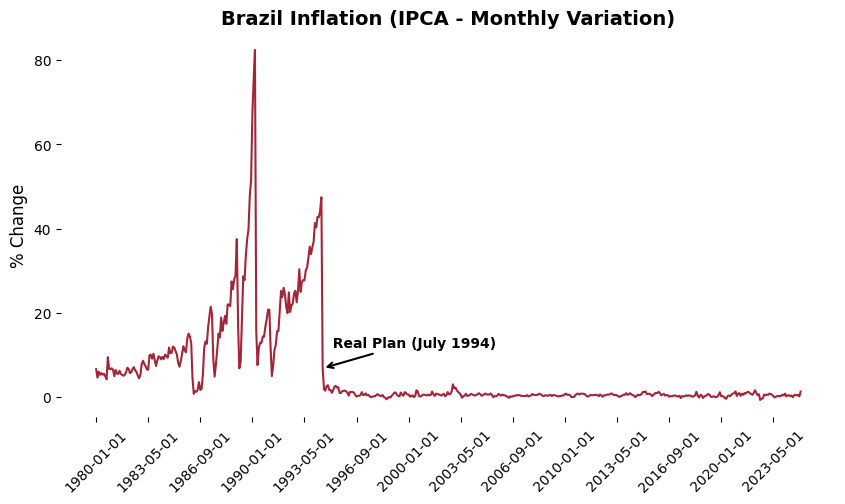

In [ ]:
## Graph

# Sort data by date
df = df.sort_values(by='date')

# Define the IPCA column
ipca_column = "ipca"

# Convert to numeric if necessary
df[ipca_column] = pd.to_numeric(df[ipca_column], errors='coerce')

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df[ipca_column], color=rgb_color, linewidth=1.5, label="IPCA - Monthly Variation")

plt.title('Brazil Inflation (IPCA - Monthly Variation)', fontsize=14, fontweight='bold')
plt.xlabel('', fontsize=12)
plt.ylabel('% Change', fontsize=12)

# Improve the X-axis, showing labels every XX periods
plt.xticks(df['date'][::40], rotation=45, fontsize=10)

# Remove background and extra borders
plt.gca().set_facecolor('white')  # Remove background color
plt.gca().spines['top'].set_visible(False)  # Remove top border
plt.gca().spines['right'].set_visible(False)  # Remove right border
plt.gca().spines['left'].set_visible(False)  # Remove left border
plt.gca().spines['bottom'].set_visible(False)  # Remove bottom border

plt.grid(False) # Remove grid lines

# Highlight July 1994 (Real Plan) with a vertical dashed line
cutoff = pd.to_datetime('1994-07-01')
# plt.axvline(x=cutoff, color='black', linestyle='--', linewidth=1.5, label="Real Plan (July 1994)")

# Try to get the IPCA value for July 1994
value_cutoff = df.loc[df['date'] == cutoff, ipca_column]

if not value_cutoff.empty:
    value_cutoff = value_cutoff.values[0]
else:
    value_cutoff = df[ipca_column].max() * 0.9  # Set to 90% of the max if not found

# Add annotation with arrow
plt.annotate(
    "  Real Plan (July 1994)",
    xy=(cutoff, value_cutoff),  # Arrow pointing to the Real Plan date
    xytext=(cutoff, value_cutoff + 5),  # Text position above the point
    arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle="->", lw=1.5),
    fontsize=10, color='black', fontweight='bold'
)

# plt.legend()
plt.show()

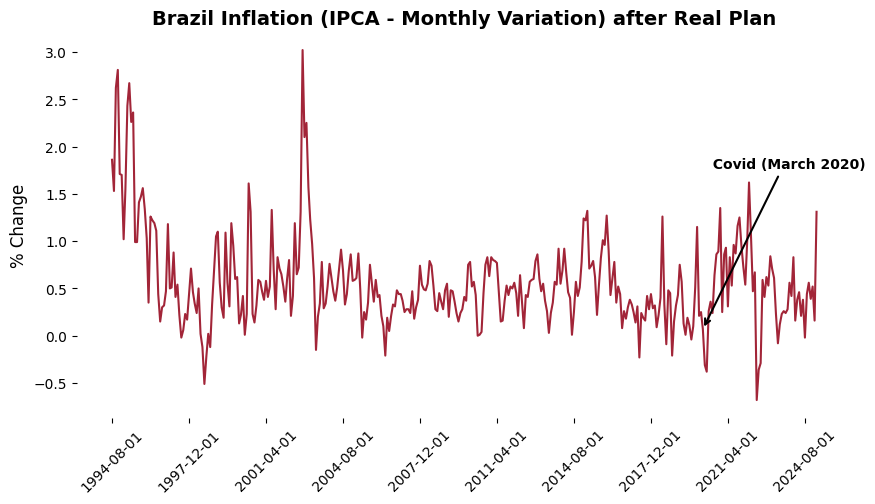

In [37]:
## Graph 2

# Sort data by date
df = df.sort_values(by='date')

# Define the IPCA column
ipca_column = "ipca"

# Convert to numeric if necessary
df[ipca_column] = pd.to_numeric(df[ipca_column], errors='coerce')

# Define the cutoff date (July 1994)
start_date = pd.to_datetime('1994-07-01')

# Filter data from July 1994 onwards
df_1 = df[df['date'] > start_date]

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(df_1['date'], df_1[ipca_column], color=rgb_color, linewidth=1.5, label="IPCA - Monthly Variation")

plt.title('Brazil Inflation (IPCA - Monthly Variation) after Real Plan', fontsize=14, fontweight='bold')
plt.xlabel('', fontsize=12)
plt.ylabel('% Change', fontsize=12)

# Improve the X-axis, showing labels every XX periods
plt.xticks(df_1['date'][::40], rotation=45, fontsize=10)

# Remove background and extra borders
plt.gca().set_facecolor('white')  # Remove background color
plt.gca().spines['top'].set_visible(False)  # Remove top border
plt.gca().spines['right'].set_visible(False)  # Remove right border
plt.gca().spines['left'].set_visible(False)  # Remove left border
plt.gca().spines['bottom'].set_visible(False)  # Remove bottom border

# Remove grid lines
plt.grid(False)

# Highlight March 2020 (Covid) with a vertical dashed line
cutoff = pd.to_datetime('2020-03-01')
# plt.axvline(x=cutoff, color='black', linestyle='--', linewidth=1.5, label="March 2020 (Covid)")

# Try to get the IPCA value for March 2020
value_cutoff = df_1.loc[df_1['date'] == cutoff, ipca_column]

if not value_cutoff.empty:
    value_cutoff = value_cutoff.values[0]
else:
    value_cutoff = df_1[ipca_column].max() * 0.9  # Set to 90% of the max if not found

# Add annotation with arrow
plt.annotate(
    "  Covid (March 2020)",
    xy=(cutoff, value_cutoff),  # Arrow pointing to the Real Plan date
    xytext=(cutoff, value_cutoff + 1.7 ),  # Text position above the point
    arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle="->", lw=1.5),
    fontsize=10, color='black', fontweight='bold'
)

# plt.legend()
plt.show()

#### Descriptive Analysis

#### Testing for Stationarity Using the Dickey-Fuller Method

##### NOT stationary - Before Real Plan

In [38]:
result = adfuller(df['ipca'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Check if the series is stationary
if result[1] > 0.05:
    print("The time series is NOT stationary (p-value > 0.05). Differentiation is required.")
else:
    print("The time series is stationary (p-value ≤ 0.05). No differentiation needed.")

ADF Statistic: -2.369808851710225
p-value: 0.1504395473662637
The time series is NOT stationary (p-value > 0.05). Differentiation is required.


In [22]:
df['ipca_diff'] = df['ipca'].diff().dropna()

# Re-run the stationarity test
result_diff = adfuller(df['ipca_diff'].dropna())
print(f'ADF Statistic (after differencing): {result_diff[0]}')
print(f'p-value (after differencing): {result_diff[1]}')

if result_diff[1] > 0.05:
    print("The time series is still NOT stationary. Another differencing may be needed.")
else:
    print("The time series is now stationary.")


ADF Statistic (after differencing): -7.7836650638064935
p-value (after differencing): 8.288671519040063e-12
The time series is now stationary.


##### Stationary - After Real Plan

In [ ]:
result = adfuller(df_1['ipca'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Check if the series is stationary
if result[1] > 0.05:
    print("The time series is NOT stationary (p-value > 0.05), we do not reject H₀. Differentiation is required.")
else:
    print("The time series is stationary (p-value ≤ 0.05), we reject H₀. No differentiation needed.")

In [ ]:
# Let's use the series after Real Plan
df = df_1

del df_1

#### Autocorrelation Function ( ACF ) and Partial Autocorrelation Function (PACF)

<Figure size 1000x500 with 0 Axes>

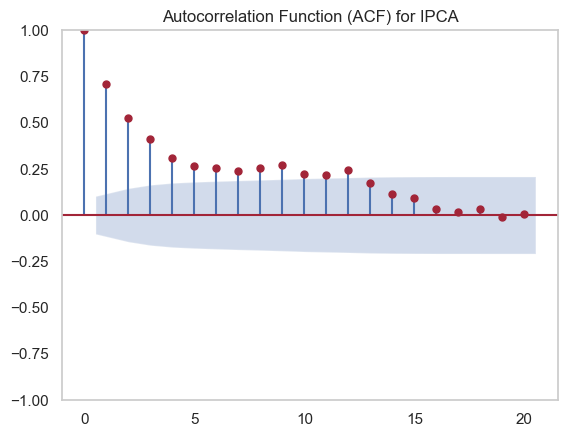

In [ ]:
plt.figure(figsize=(10, 5))
plot_acf(df['ipca'], lags=20, color=rgb_color)
plt.title("Autocorrelation Function (ACF) for IPCA")
plt.grid(False) # Remove grid lines
plt.show()

#### Partial Autocorrelation Function (PACF)

<Figure size 1000x500 with 0 Axes>

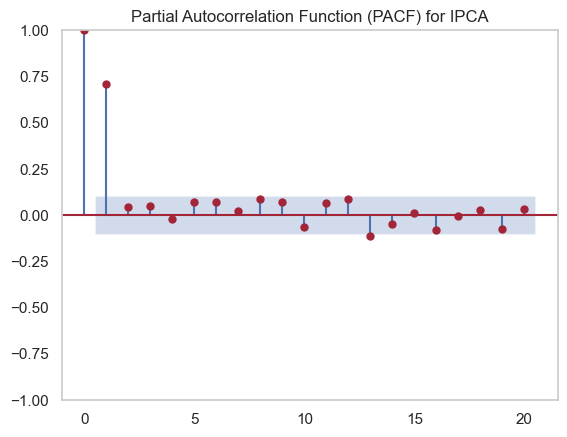

In [76]:
plt.figure(figsize=(10,5))
plot_pacf(df['ipca'], lags=20, method='ywm', color= rgb_color)
plt.title("Partial Autocorrelation Function (PACF) for IPCA")
plt.grid(False) # Remove grid lines
plt.show()


#### XXX

In [96]:
from pm import auto_arima

# Selecionar o melhor modelo ARIMA automaticamente
best_model = auto_arima(df['ipca'],
                        start_p=0, max_p=5,  # Testa valores de p entre 0 e 5
                        start_q=0, max_q=5,  # Testa valores de q entre 0 e 5
                        d=0,                 # Mantemos d=0 pois a série é estacionária
                        seasonal=False,      # Sem sazonalidade (SARIMA seria para dados sazonais)
                        stepwise=True,       # Otimização mais rápida
                        trace=True)          # Exibe o progresso do ajuste

# Exibir o melhor modelo encontrado
print(best_model.summary())


ModuleNotFoundError: No module named 'pm'

#### XXX

## GDP